# Phylogenetics in Practice: Day I
## Preliminaries
Make sure to *Select kernel* to run the R code in this iPython notebook. Look under *Jupyter Kernel...*, *R*.

To progress through the practical use `Shift Enter` to move from one cell to the next.

## Introduction

At the beginning of 2015, several cases of patients presenting symptoms of mild fever, rash, conjunctivitis and joint pain were reported by clinicians in South America. Investigation revealed infections with Zika virus, an obscure relative of dengue and chikungunya, that until the late 2000s had caused sporadic benign infections in Africa and Asia. Outbreaks emerged in Micronesia in 2007 and French Polynesia in 2013-14, during which an unusual increase in the incidence of severe neurological complications was first noticed. Over the course of 2015 and into 2016, clinicians in Brazil reported an upswing in the numbers of children born with microcephaly. The finger of blame was pointed towards Zika virus, a flavivirus, members of which group had been known to exhibit neurotropism and thereby carry the risk of causing neurological defects. As of March 2016, the epidemiological history and expectations for the ongoing spread of Zika virus were very uncertain.

The purpose of this practical is to demonstrate the tools available for phylogenetic analysis during early outbreak investigation. The aims are to address the following questions:
- What was the geographic origin of the 2015/2016 Zika outbreak?
- How was the virus related to previous Zika outbreaks?
- When did the 2015/2016 Zika virus strain diverge from other variants?
- Was there anything special about the 2015/2016 strain?
- At what speed was Zika virus spreading through South America?
- Could we have predicted the total number of cases?

## Genome Sequences

As of January 2016, only a modest number of Zika virus whole, or near-whole, genome sequences were available:

<iframe src="https://docs.google.com/spreadsheets/d/e/2PACX-1vS8yll6PC_F0ermshphnLg4ON21mMmGm3FXBOp9IRS3NlGG20L8VusTTryHzrf4PBAvNU1kN_TeK5Mo/pubhtml?widget=true&amp;headers=false" width="100%"></iframe>

Click [here](https://docs.google.com/spreadsheets/d/1tqKzU8rquKbkBbPqmRg6yW2jtt9EuQYjpHKq2mPAgaY/edit?usp=sharing) for the Google Doc. The first step in the analysis is to obtain the whole genome sequences from Genbank using the accession numbers provided in publications or found through a Genbank search query.

<!-- In your web browser, navigate to https://www.ncbi.nlm.nih.gov/genbank/ -->

> - [Navigate to this Terminal](https://localhost:14501) and type `firefox &`
> - Once Firefox opens, paste `www.ncbi.nlm.nih.gov/genbank` into the URL bar

Copy the accession numbers from the spreadsheet and paste them into the query box, and click search. The 31 sequences will appear, split across two pages.

<center><img src="src/Screenshot_genbank.png" width="30%"></center>

To show the sequences, click Summary, FASTA, and to download click Send to: File. (Leave *Complete Record* checked). By default, it will save the genomes to a file called sequence.fasta.txt in your working directory.

> Your working directory has different names from inside and outside the docker container. From inside docker, its location is `/home/student`.

## Multiple Sequence Alignment

Phylogenetic reconstruction relies on the identification of character traits whose patterns of presence and absence is informative about shared evolutionary ancestry. In the past, many traits were used, but modern phylogenetics utilizes, almost exclusively, molecular sequence traits: DNA, RNA or protein sequences.

To compare any character across individuals, first *homology* must be established. Only traits that are *homologous*, i.e. directly co-inherited, can be used as the basis for valid comparison. Therefore the first challenge is to identify sequence homology between the virus genomes. By visualizing the Zika genomes in jalview, you will see they are all different lengths, partly because of differences in primers used for sequencing, partly because of mutations.

<!--Open [jalview](http://localhost:14502).-->

> - [Navigate to this Terminal](https://localhost:14501) and type `AWT_TOOLKIT=MToolkit _JAVA_OPTIONS='-Dsun.java2d.uiScale=1' /usr/bin/jalview &`

In jalview, open the genomes you downloaded via the File, Input Alignment, From File menu, and navigating to sequence.fasta.txt in your Downloads directory, which is `/home/student/Downloads` from inside docker.

You can assist visualization by selecting, from the menu, Colour, Nucleotide. Scanning through the sequences you will notice that there are similarities between some of the genomes, but it is very messy and inconsistent.

<center><img src="src/Screenshot_unaligned.png" width="30%"></center>

We're going to use *mafft* to align the sequences by identifying regions of sequence similarity. Sequences will be padded with indels (- characters, representing insertions or deletions) to improve the similarity within columns of the sequence alignment.

Open [the Terminal](http://localhost:14501). Typing *mafft -h* will produce a bewildering list of all the mafft options. Multiple sequence alignment is a very difficult problem in bioinformatics and even the most popular aligners can only be considered heuristic at best. In this practical, I will give you a recipe for aligning the sequences. If you want to learn more, Google for *mafft* and read the online documentation as a starting point.

In the Terminal, navigate to your working folder and run mafft as follows (increase the --thread option if you want to use more than two processors)

> Some users have found they need to replace `sequence.fasta` with `sequence.fasta.txt` in the command above. Type `cat sequence.fasta` to check the file exists and is not empty.

This will take about 10 minutes with two processors (depending on your machine). Once the alignment is complete, you can open the `/home/student/work/genomes.mafft.fasta` file in jalview.

<!-- If the process says it was killed, you may need to increase the maximum system memory docker is allowed to use.-->

A good alignment between sequences that are genuinely homologous should
- Maximize the percent identity in each column of the alignment
- Produce a sequence alignment which is not spuriously longer than the original sequences
- Not contain indels for the majority of sequences in most parts of the alignment

Between closely related individuals, the sequences should be identical for most of their length. The quality of the alignment is critical to all downstream analyses because they are based on the *differences* that remain between the sequences after alignment. These differences are phylogenetically informative, and they can be better visualized by selecting from the menu Colour, Percent Identity.

<center><img src="src/Screenshot_aligned.png" width="30%"></center>

### Basic alignment summaries

Before moving on to phylogenetic reconstruction, we're going to quantify the alignment quality in R. The following commands should run inside the iPython notebook.

> You may wish to periodically save your work in R with `save.image()`. If reloading your codespace use `setwd("~/work"); load(".RData")`

In [5]:
#To load the functions for reading the alignment, type
source("https://raw.githubusercontent.com/danny-wilson/danny-wilson.github.io/main/files/fasta.R")
#Read in the alignment
setwd("~/work")
a = toupper(read.fasta("genomes.mafft.fasta",as.char=TRUE))

In [6]:
#Number of sequences 
nrow(a)

[1] 31

In [7]:
#Alignment length
ncol(a)

[1] 10836

In [8]:
#Maximum sequence length
max(rowSums(a!='-'))

[1] 10808

In [9]:
#Number of sites with one or more indel: for closely related sequences, most sites would not be expected to be indels, although differences in primers may exacerbate indel rates near the ends of the sequences
sum(colSums(a=='-')>0)

[1] 998

In [10]:
#Total frequency of indels in the alignment
mean(a=='-')

[1] 0.03097798

When I ran through the practical, the total alignment length was 10836 bases, only 0.2% longer than the longest sequence (10808 bases), indicating that mafft had found the sequences to be largely collinear, and had introduced indels only sparingly. Although 998 columns had at least one indel, only 3.1% of all bases were indels. These summary statistics indicated no major problems with the alignment process.

### Tidying up the alignments

Nevertheless, sequence alignments can contain a variety of idiosyncrasies that are helpful to address prior to downstream analysis so they do not cause analysis artifacts. It is also helpful to tidy up the sequences before quantifying the sequence similarity of aligned bases.

In [ ]:
#Nucleotide composition: should be in keeping with known base frequencies in the organism.
table(a)

a
    A     C     G     N     T 
92015 73562 97738  1032 71569 

In [3]:

#Because of sequencing quality limitations, there are often ambiguous base calls such as R (purine, A/G), Y (pyrimidine, C/T) and N (any), in addition to the indel symbol (-). Downstream analyses differ in their treatment of such ambiguity codes. However, they are all roughly equivalent in the sense that they convey little or no information as to what the base would have been. Therefore to simplify matters, it is reasonable to replace them all with 'N'. 
gd = a=='A' | a=='C' | a=='G' | a=='T' | a=='U' | a=='N'
a[!gd] = 'N'

In [13]:

#For RNA sequences, there can be inconsistency in whether uracil or its DNA counterpart thymine is reported. When sequences come from different sources, they might use different conventions. To simplify matters, replace all uracil codes with thymines.
a[a=='U'] = 'T'

In [14]:

#In downstream analyses, computational complexity strongly depends on the number of different phylogenetic patterns, i.e. the occurrence of As/Cs/Gs/Ts/Ns across individuals in a single column of the alignment. Ambiguous base calls that are scattered throughout the alignment fairly randomly can massively increase the number of different phylogenetic patterns. Particularly for columns that are otherwise invariant, this added cost comes with no benefit because only variable bases are phylogenetically informative. Therefore, it is reasonable at invariant sites to replace Ns with the consensus base.
cons = apply(a,2,function(x) names(sort(table(ifelse(x=='N',NA,x)),decreasing=TRUE))[1])
is.variable = apply(a,2,function(x) nlevels(factor(ifelse(x=='N',NA,x)))>1)
a[,!is.variable] = sapply(which(!is.variable),function(j) ifelse(a[,j]=='N',cons[j],a[,j]))

In [15]:

#The sequence labels in Genbank are often long and contain unusual characters that can upset downstream analysis programs. Truncate them at the first space
lab = sapply(rownames(a),function(s) unlist(strsplit(s,' '))[1])

In [16]:

#Write the modified sequences in FASTA format
rownames(a) = lab
write.fasta(a,"genomes.relab.fasta")

In [17]:

#One of the bugbears of bioinformatics is file format conversion. Many programs use different file formats. In the phylogenetics setting, PHYLIP format is common. For later use, we're also going to write the sequences in PHYLIP format.
outfile = "genomes.relab.phylip"
nc = max(nchar(lab))
lab = sapply(lab,function(s) paste0(s,paste0(rep(" ",nc-nchar(s)),collapse="")))
cat(nrow(a),ncol(a),file=outfile)
cat("\n",file=outfile,append=TRUE)
for(i in 1:nrow(a)) {
  cat(lab[i],paste0(a[i,],collapse=""),file=outfile,append=TRUE)
  cat("\n",file=outfile,append=TRUE)
}

### Basic diversity measures

As a way of familiarizing yourself with the sample, it is helpful to quantify the relatedness of the individuals in terms of nucleotide similarity and total number of variable sites. Basic measures of pairwise genetic diversity between individuals also provide the starting point for distance-based phylogenetic tree building.

In [18]:
#Number of variable sites: for closely related sequences, most sites would not be expected to vary
(S = sum(colSums(t(t(a)!=cons))>0))

[1] 4362

In [19]:

#Mean pairwise diversity: the mean, across all pairs of sequences, of the proportion of the sequence at which they vary. For closely related sequences, should be much less than 0.1
a2i = c('A'=1,'C'=2,'G'=3,'T'=4)
i = matrix(a2i[a],nrow(a),ncol(a))
DIST = rowMeans(apply(i,2,dist)>0,na.rm=TRUE)
(PI = mean(DIST))

[1] 0.08700187

In [20]:

#Distribution of pairwise diversity across sequences
summary(DIST)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0001848 0.0257933 0.1064007 0.0870019 0.1089696 0.2998980 

The number of variable sites (4362/10835) and the mean pairwise diversity (0.087) are perhaps on the high side. Since the alignment quality metrics gave no cause for concern, this could indicate the presence of one or more outlier genomes in the sample, or it might simply reflect the high inherent diversity of the viruses.

## Phylogenetic Reconstruction

### Distance-based methods

The simplest methods for phylogenetic reconstruction base inference directly on the pairwise genetic distance of the sequences. This throws away most of the information in the alignment by summarizing it through a simple summary statistic. For these simple distance-based methods, it is sufficient to analyse the data in R.

In [21]:
#Inspect the pairwise distance matrix 
PD = matrix(0,nrow(a),nrow(a)) 
PD[lower.tri(PD)] = DIST 
PD[upper.tri(PD)] = t(PD)[upper.tri(PD)] 
rownames(PD) = rownames(a); colnames(PD) = rownames(PD) 
#Only a limited number of rows and columns will fit on the screen 
PD[1:5,1:5] 

,KU365777.1,KU365780.1,KU365779.1,KU312312.1,KU365778.1
KU365777.1,0.0000000000,0.0001848429,0.0003696858,0.002592593,0.002772643
KU365780.1,0.0001848429,0.0000000000,0.0005545287,0.002407407,0.002587800
KU365779.1,0.0003696858,0.0005545287,0.0000000000,0.002222222,0.002402957
KU312312.1,0.0025925926,0.0024074074,0.0022222222,0.000000000,0.002407407
KU365778.1,0.0027726433,0.0025878004,0.0024029575,0.002407407,0.000000000


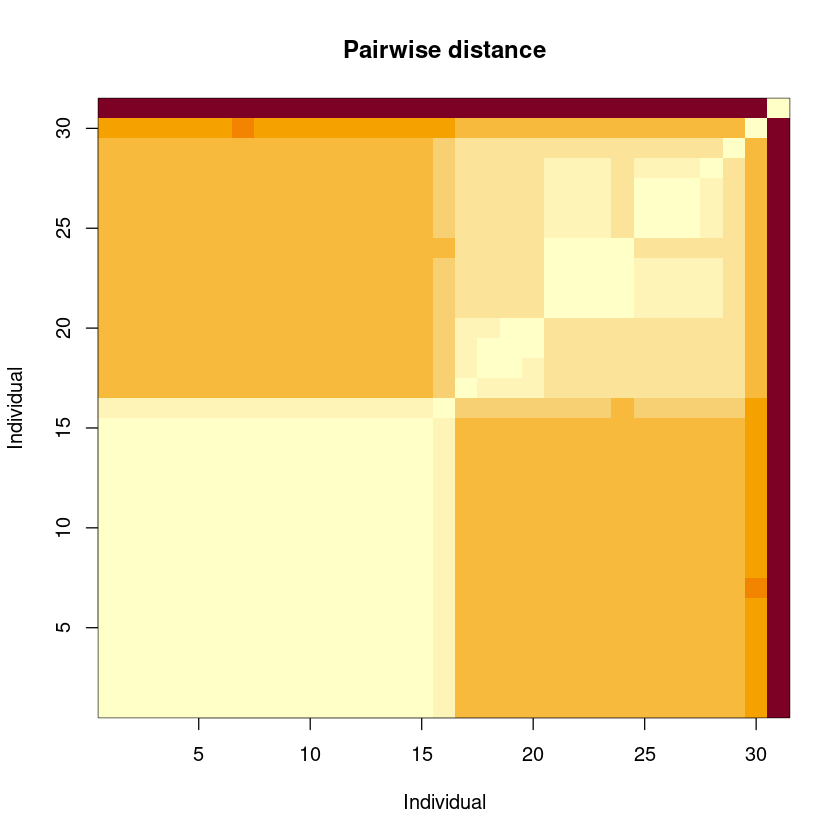

In [22]:

#Visualize as an image: because we used the --reorder option in mafft, this immediately reveals relatedness structure in the data 
image(1:nrow(a),1:nrow(a),PD,xlab="Individual",ylab="Individual",main="Pairwise distance") 

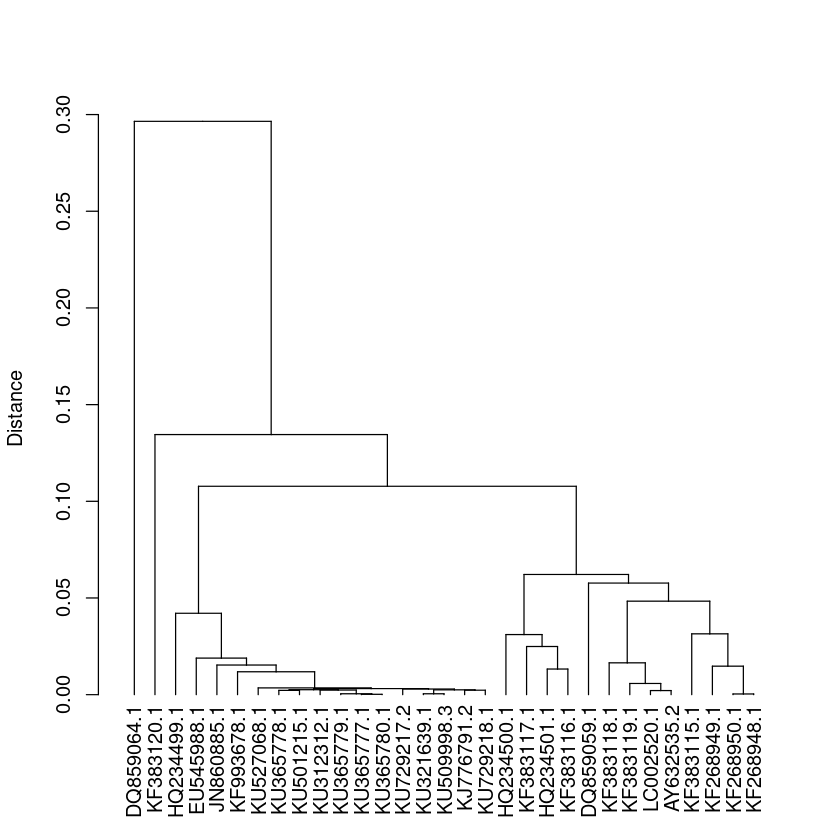

In [24]:

#One of the simplest ways to infer a phylogenetic tree is with UPGMA (Unweighted Pair Group Method with Arithmetic Mean). This is a clustering algorithm that iteratively joins the branches ancestral to the most similar sequences, computing similarity iteratively as the mean between each pair of groups that are merged when their branches are joined. 
upgma.tree = as.dendrogram(hclust(as.dist(PD),method="average")) 
par(bg="white");plot(upgma.tree,xlab="",ylab="Distance") 

<!--<center><img src="src/Screenshot_upgma.png" width="30%"></center>-->

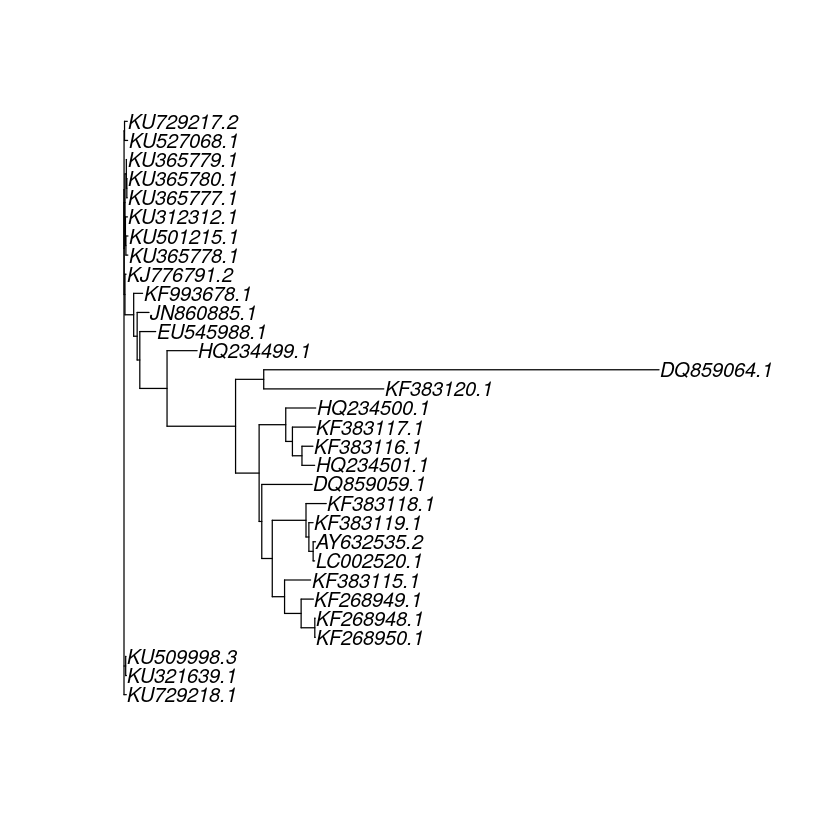

In [27]:
#The phangorn package allows us to use neighbour joining, another distance-based method, instead.
require(phangorn)
nj.tree = NJ(PD)
par(bg="white"); plot(nj.tree)

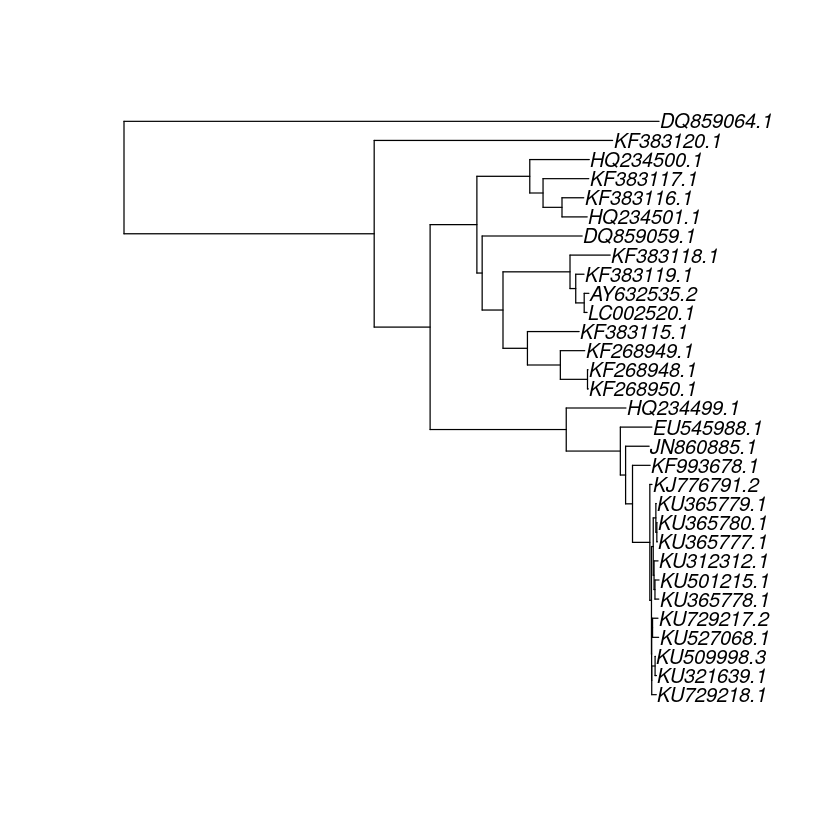

In [28]:

#The resulting tree needs to be rooted. A simple method is midpoint rooting.
nj.tree = midpoint(NJ(PD))
par(bg="white"); plot(nj.tree)

> You can save your current R session to the working directory with the save.image() command. Later, reload it with `setwd("~/work"); load(".RData")`

In [29]:
save.image()

Distance-based methods are quick and often referred to as dirty. Among the limitations of distance-based methods
- The methods are ad hoc algorithms that do something sensible at each step, but do not add up to a principled approach to inference
- In particular, there is no explicit model of evolution, making the assumptions difficult to scrutinize
- With no probabilistic model of sequence evolution, no theoretical guarantees of performance can be applied to these methods
- For the same reason, it is difficult to quantify statistical uncertainty associated, although bootstrapping is commonly employed
- Since information is thrown away when summarizing the sequences by pairwise distance alone, distance methods cannot be expected to perform as well as alternatives based on the full data
- In practice, these concerns are born out with worse empirical performance than more sophisticated alternatives

Distance-based methods are certainly quick, but in practice their accuracy is often not horribly worse than sophisticated alternatives. While they are useful data visualization tools, there is no good reason not to apply more accurate methods wherever possible.

### Maximum likelihood methods

Maximum likelihood (ML) methods apply an explicit, probabilistic, model of sequence evolution to the full sequence data, and estimate the tree and branch lengths through a principled statistical approach. ML methods are
- Consistent, meaning that as more data becomes available, the estimate gets better
- Unbiased for large datasets
- Amenable to formal hypothesis tests and construction of confidence intervals

ML methods attempt to find the tree and branch lengths that are most compatible with the data. They consider how probable the observed data would have been for different trees and branch lengths. No matter how improbable the observed data are, they optimize the tree and branch lengths so that no alternative tree and branch lengths could make the observed data more probable.

In practice, it is usually impossible to guarantee that a computer algorithm has found the global maximum likelihood estimates because the number of tree topologies is too large to explore exhaustively: for $n$ sequences there are
$$ (2n-5)(2n-7)(2n-9) ... (5)(3)(1) $$
possible unrooted bifurcating labelled trees. Instead, various search strategies are employed that aim to find the best possible estimate in a reasonable amount of time. These algorithms often use distance-based methods as a starting point.

Since maximum likelihood methods must be highly optimized, most widely-used methods are available as stand-alone command line programs. We will use *PhyML* which is simple to use and fast up around 200 sequences. Beyond that there are more specialized tools such as *RAxML*.

Open the Terminal. The following command will launch PhyML

Typing `phyml -h` will list all the options. The above command line implies the following defaults:
- -d nt specifies nucleotide not amino acid sequences
- -p instructs PhyML to initialize the search with a minimum parsimony (distance-based) tree
- -m HKY85 specifies the Hasegawa, Kishino and Yano (1985) model of nucleotide sequence evolution
- -f e indicates that nucleotide frequencies should be estimated from the empirical frequencies in the alignment
- -t e implies that the transition:transversion ratio parameter should be estimated by maximum likelihood along with the tree and branch lengths

The explicitly selected options do the following:
- -i specifies the Phylip format sequence alignment
- -b 0 instructs PhyML not to perform bootstrap replicates
- -v 0 -c 1 indicates that a single substitution rate should be applied to all columns in the alignment
- -s BEST combines NNI and SPR search strategies

When I ran through the practical, this command took 40 seconds to run. Note that bootstrapping is considered good practice as a means of quantifying the uncertainty in the estimated tree. Typically, 100 or more bootstrap replicates are conducted and the tree plotted with bootstrap support (0-100) beside each split. PhyML can perform regular and approximate bootstrap, and you are free to explore these capabilities.

The tree can be visualized, for example in [figtree](http://localhost:14504), by opening `genomes.relab.phylip_phyml_tree.txt`.

> Open `figtree &` inside the Terminal

<center><img src="src/Screenshot_MLtree.png" width="30%"></center>

Figtree has a flexible and intuitive interactive graphical interface that can be used to fine-tune how the tree is displayed. Alternatively, switching back to R, the tree can be read in and displayed.

Loading required package: phangorn

Loading required package: ape



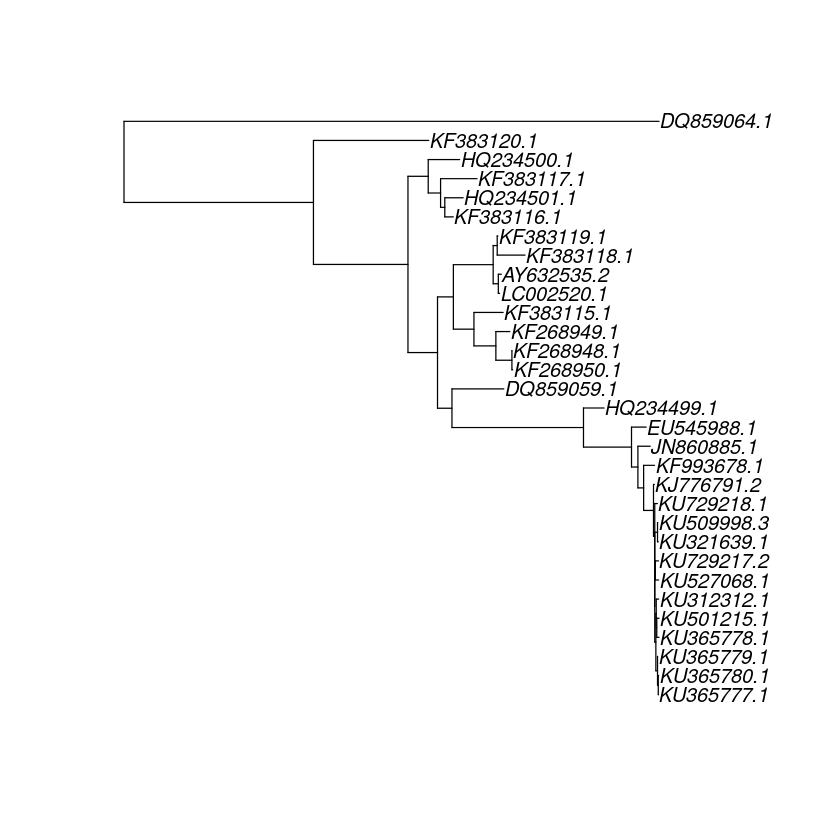

In [14]:
require(phangorn)
ml.tree = ladderize(midpoint(read.tree("genomes.relab.phylip_phyml_tree.txt")))
par(bg="white"); plot(ml.tree)
#Output the midpoint rooted version for later use
write.tree(ml.tree,"genomes.midpoint.tree.txt")

For users with the time to learn, R provides even more fine-grained control over the way the tree is displayed. See the ape package documentation for details.

> In R access help by preceding any command with a question mark, e.g. `?ladderize`

Among the benefits of ML methods is the interpretability of the estimated tree. For instance, the branch lengths report the *expected number of substitutions* per site along the branch, given the data and the assumed model of sequence evolution. This provides an alternative to the 'raw' pairwise genetic distance by calculating the sum of branch lengths between each pair of sequences, a quantity known as the phylogenetic or *cophenetic* distance. In R, it can be obtained by

In [15]:
# Pairwise phylogenetic distance matrix
TPD = cophenetic(ml.tree)
summary(TPD[lower.tri(TPD)])

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0001849 0.0282196 0.1367859 0.1215178 0.1483833 0.5359174 

In [16]:
# Mean branch length 
mean(ml.tree$edge.length)

[1] 0.01375864

When I ran the code, I obtained a mean phylogenetic distance of 0.14, indicating that on average 14 substitutions per 100 bases separate each pair of genomes, somewhat higher than the mean pairwise genetic distance of 0.087. Usually phylogenetic distance is higher than genetic distance because
- ML methods can account for the saturating effect of repeat mutation on 'raw' genetic distance
- Missing bases in the alignment caused by ambiguity or indels can be imputed by ML methods, and may increase the distance
- Recombination can artificially inflate phylogenetic distances by giving the appearance of repeat mutation

The problem of recombination and detecting it in phylogenies is the subject of the next section.

### Rooting out recombination

A key assumption of phylogenetics methods is that recombination, also known as horizontal gene transfer, has not played an important role in the ancestral history of the sample. In other words, a single tree is assumed to accurately represent the relatedness of the individuals at all positions in the sequence.

This contrasts strongly with the assumption of a pedigree - e.g. your family tree - in which recombination is expected to have occurred every generation. This is why you get half of each paternally-inherited autosome (chromosomes 1-22) from your paternal grandfather and grandmother respectively, and half of each maternally-inherited autosome from your maternal grandfather and grandmother respectively. So there is a change in ancestry along every chromosome for every generation in your pedigree. This means that relatedness in any population changes constantly throughout the human autosome sequences.

Trying to reconstruct a single tree from highly recombining sequences is a case of model misspecification and risks misleading inference. This is why it is important to
- Ask whether it is sensible to reconstruct a phylogeny in the first place
- Test for evidence of recombination in the estimated phylogeny
  
Unlike humans, most infectious organisms are not obligately sexual, and therefore recombination might be rare or absent. In this practical, we will use ClonalFrameML to test for evidence of recombination in the sequences.

<table border="0" style="margin-left: auto; margin-right: auto; text-align: left;">
<tbody>
<tr>
<th style="text-align: center;"></th>
<th style="text-align: center;">A</th>
<th style="text-align: center;">C</th>
<th style="text-align: center;">G</th>
<th style="text-align: center;">T</th>
</tr>
<tr>
<td style="text-align: center;"><b>A</b></td><td style="text-align: center;"><i>-</i></td>
<td style="text-align: center;"><i>f<sub>C</sub></i></td>
<td style="text-align: center;"><i>κf<sub>G</sub></i></td>
<td style="text-align: center;"><i>f<sub>T</sub></i></td>
</tr>
<tr>
<td style="text-align: center;"><b>C</b></td><td style="text-align: center;"><i>f<sub>A</sub></i></td>
<td style="text-align: center;"><i>-</i></td>
<td style="text-align: center;"><i>f<sub>G</sub></i></td>
<td style="text-align: center;"><i>κf<sub>T</sub></i></td>
</tr>
<tr>
<td style="text-align: center;"><b>G</b></td><td style="text-align: center;"><i>κf<sub>A</sub></i></td>
<td style="text-align: center;"><i>f<sub>C</sub></i></td>
<td style="text-align: center;"><i>-</i></td>
<td style="text-align: center;"><i>f<sub>T</sub></i></td>
</tr>
<tr>
<td style="text-align: center;"><b>T</b></td><td style="text-align: center;"><i>f<sub>A</sub></i></td>
<td style="text-align: center;"><i>κf<sub>C</sub></i></td>
<td style="text-align: center;"><i>f<sub>G</sub></i></td>
<td style="text-align: center;"><i>-</i></td>
</tr>
</tbody>
</table>
<div style="text-align: center;">
<span style="font-size: x-small;"><b>The HKY85 substitution model</b></span><br />
<span style="font-size: x-small;">The rate of substitution from one base to another is assumed to be proportional to the overall frequency of that base (<i>f<sub>A,</sub></i><i>f<sub>C,</sub></i><i>f<sub>G</sub></i><i><sub>,</sub></i><i>f<sub>T</sub></i>), adjusted by a factor <i>κ</i> representing the relative rate of transitions (purine-to-purine or pyrimidine-to-pyrimidine) versus transversions (purine-to-pyrimidine or <i>vice versa</i>).</span></div>

ClonalFrameML assumes an HKY85 substitution model and takes the ML phylogeny as input. To extract the ML estimate of the transition:transversion ratio from the PhyML output, type at [the Terminal](http://localhost:14501)

Inserting this value into the `-kappa` argument (I got 4.6), run ClonalFrameML by typing in the Terminal


Once this has finished running, we should be able to view the output file at `zika.cfml.pdf` (navigate in the side-bar).
<!--0(vscode:///home/student/work/zika.cfml.pdf)`. -->

There are a large number of options which are summarized by running ClonalFrameML with no trailing arguments.  We have modified only two arguments compared to their default settings, the transition:transversion ratio as mentioned above, and the mean and standard deviation (sd) of the prior distribution of the branch lengths of the tree. ClonalFrameML is a Bayesian method (more on this later) and uses prior knowledge to help inform its parameter estimates. The prior knowledge on four parameters is represented by gamma distributions with means and standard deviations specified on the command line. The fourth parameter is the branch length, and I have set this to have a prior mean and standard deviation roughly equal to the mean branch length in the ML tree.

This analysis took 45 seconds to run for me. ClonalFrameML produces a pdf file showing the recombination-corrected phylogeny against a plot of the positions of substitutions (small vertical bars) and recombination events (long horizontal dark blue lines) in the ancestry history of the sequences.

<center><img src="src/Screenshot_CFML.png" width="30%"></center>

The presence of multiple long horizontal dark blue lines indicates there have been numerous recombination events in the history of the sequenced genomes. You can see that in any particular row, these recombination events pick out heterogeneity in the substitution density across the genome (left to right) on the corresponding branch of the tree.

The deep branches of the phylogeny in particular seem to have been the focus of recombination. This suggests recombination may have been an important force early in the evolutionary history of these genomes. In contrast, there is very little recombination near the tips of the tree, indicating that recombination has been rare or absent during recent evolution.

Most of the recombination appears to have occurred on the branches leading to the Senegal sequences KF383120 (ArD 142623), KF383117 (ArD 128000) and KF383118 (ArD 157995), which were sampled between 1997 and 2001, and the branch separating KF383120 and DQ859064 (the Spondweni virus outgroup). This will be important to bear in mind when interpreting the phylogeny, particularly because recombination can distort the tree and cause misleading inference of relationships between sequences. Where there has been no recombination between sequences, we can reconstruct the phylogenetic subtree with more confidence.

### Phylogeography

With access to good metadata such as geographic sampling locations and host species, one can use the phylogeny to investigate the origin and spread of the outbreak geographically and between host species.

The Google Docs [spreadsheet](https://docs.google.com/spreadsheets/d/1tqKzU8rquKbkBbPqmRg6yW2jtt9EuQYjpHKq2mPAgaY/edit?usp=sharing) presented earlier contains metadata on the year, country and host species from which the viruses were sampled.

<iframe src="https://docs.google.com/spreadsheets/d/e/2PACX-1vS8yll6PC_F0ermshphnLg4ON21mMmGm3FXBOp9IRS3NlGG20L8VusTTryHzrf4PBAvNU1kN_TeK5Mo/pubhtml?widget=true&amp;headers=false" width="100%"></iframe>

We can visualize these data directly on the phylogeny. 

> - Open [the Terminal](http://localhost:14501)
> - Open a web browser by typing `firefox &`
> - Copy this URL and paste it into the firefox URL bar:
> -- `https://docs.google.com/spreadsheets/d/1tqKzU8rquKbkBbPqmRg6yW2jtt9EuQYjpHKq2mPAgaY/edit?usp=sharing`
> - Once in Google Docs, select from the menu %File, Download, Comma-separated values (.csv)*. This will download the spreadsheet to your Downloads folder.
> - You will need to move the .csv file from your Downloads folder to your working directory, unless they are the same, using the Terminal command `cp "~/Downloads/Zika Genomes Jan 2016 - .csv" ~/work/`

The Genbank accession numbers approximately match the sequence labels in the phylogeny. To obtain an exact match, we manipulate the annotation file in R:

In [17]:
annot = read.csv("Zika Genomes Jan 2016 - .csv")
annot2tree = sapply(annot$Genbank.accession,function(acc) grep(acc,ml.tree$tip.label))
annot = cbind("label"=ml.tree$tip.label[unlist(annot2tree)],annot)
#Save as a tab-deliminted file
write.table(annot,"zika.annotations.txt",row=F,col=T,quote=F,sep="\t")

Return to the Terminal and launch figtree by typing `figtree &`. Once launched, open either:
- the ML tree `genomes.midpoint.tree.txt`, or
- the ClonalFrameML recombination-corrected phylogeny, `zika.labelled_tree.newick`

Open the annotation file by selecting, from the menu, File, Import Annotations and locate the `zika.annotations.txt` file in your Downloads folder.

Expand the *Tip labels* panel in the side bar on the left of figtree. There are drop-down menus for selecting the information to *Display* at the tips of the phylogeny and to Colour by. In addition to the labels, you should now also see Continent, Country, Host and Year, among others. Try experimenting.

<center><img src="src/Screenshot_phylogeog.png" width="30%"></center>

Can you answer the following questions? Record your results as you go.
- What was the geographic origin of the 2015/2016 Zika outbreak?
- How was the virus related to previous Zika outbreaks?

There are methods that formally estimate rates of migration between populations, which may be defined for example as countries, continents or host species. If you are interested in these phylogeography methods, I recommend you look up BASTA ([De Maio, Wu, O'Reilly, Wilson 2015 PLoS Genetics 11: e1005421](http://journals.plos.org/plosgenetics/article?id=10.1371/journal.pgen.1005421)) which is implemented in BEAST2.

### Calibrating the timescale of Zika virus evolution

There appears to be strong geographic and temporal structuring among the Zika virus sequences. In the following, we are going to focus on the 2015/2016 outbreak virus and its immediate forebears. Returning to R, we will treat HQ234499 as the outgroup and drop all sequences that are more remotely related to the South American outbreak.

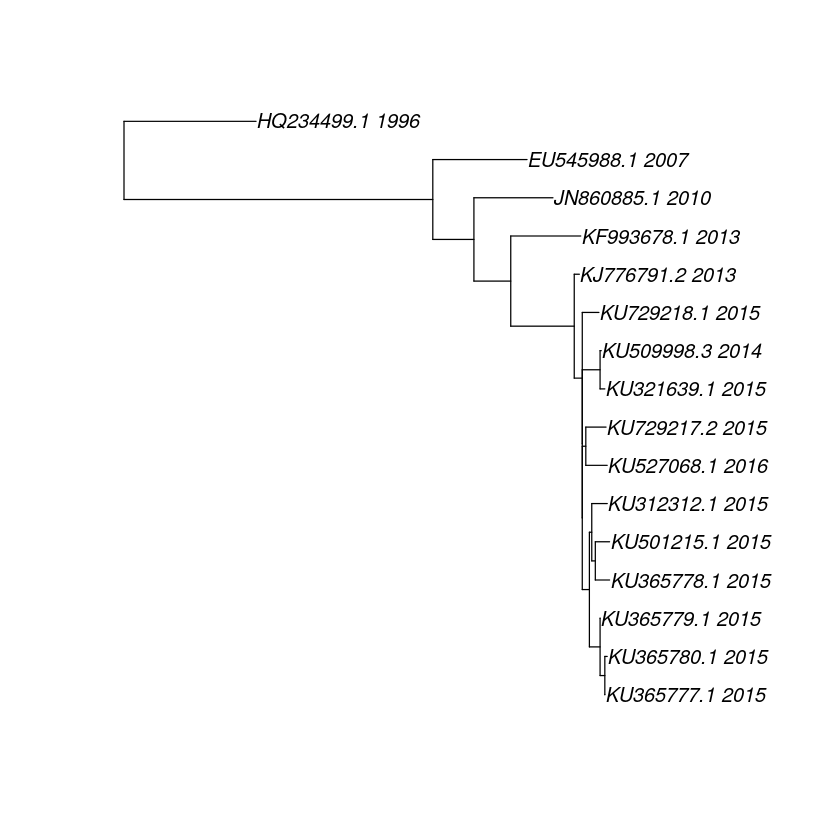

In [18]:
subtree.MRCA = getMRCA(ml.tree,c("KU365777.1","HQ234499.1"))
subtree = extract.clade(ml.tree,subtree.MRCA)
#For the next analysis it is necessary to append the tip labels with their sampling dates
subtree$tip.label = paste(subtree$tip.label,annot$Year[match(subtree$tip.label,annot$label)],sep="_")
par(bg="white"); plot(subtree)
write.tree(subtree,"genomes.subtree.txt")

Is there enough information to estimate the rate of evolution in the Zika virus genomes? For this analysis, it is essential there is no recombination affecting the ancestral history of the sample, which is a good reason to focus on the South American sequences alone.

Open tempest in the Terminal by typing `tempest &`. A file browser immediately opens: select the `genomes.substree.txt` file you just created.

Tempest is another program written by Andrew Rambaut with an intuitive graphical interface. Tempest tests for evidence of a statistically significant signal of measurable evolution within the sampling time range of your sequences. Obviously the sequences need to have been sampled over a sufficiently long time period for mutations to have accumulated at a significant amount.

One of the handy features of tempest is its *Parse Dates* button which automatically 'scrapes' the tip labels for date information. Click the button. Assist tempest by selecting *Defined by a prefix and its order*, selecting order second and enter an underscore (_) in the prefix box. The sampling years should magically appear when you select OK.

Explore the panels in tempest. You'll see there is a tree panel recapitulating what you plotted in R and a *Root-to-tip* panel. This takes the form of a scatterplot between the sampling dates of each tip and the phylogenetic distance of each tip from the root. When these cluster closely around the line of best fit, there is likely to be a good signal of measurable evolution.

<center><img src="src/Screenshot_tempest.png" width="30%"></center>

Take a look at the side bar on the left of tempest. Can you interpret the results to answer the questions:
- When was the most recent common ancestor (MRCA) of the subtree and what does it tell you about Zika virus evolution?
- How quickly is the Zika virus genome evolving, and in what units?
- What is the effect of re-rooting the subtree?

Can you figure out how you would answer:
- When did the 2015/2016 Zika virus strain diverge from other variants?

In the next part of the practical, we're going to estimate the speed at which Zika virus was spreading using BEAST.

In [ ]:
# Save your work before closing Codespaces by uncommenting the following:
# setwd("~/work"); save.image()

# Phylogenetics in Practice: Day II

Retrieve your work from the previous day

In [20]:
setwd("~/work"); load(".RData")

### Phylodynamics

We are interested in the following questions:
- At what speed was Zika virus spreading through South America?
- Could we have predicted the total number of cases?

To address these questions we're going to transition from a principally phylogenetics outlook into a more population genetics focused approach. We're also going to shift from *classical* statistical methods such as maximum likelihood into a *Bayesian* approach.

What are the differences?
- **Phylogenetics** is principally concerned with the reconstruction of phylogenetic trees to understand how individuals are related.
- **Population genetics** views the phylogeny as secondary in importance, a means to the broader end of understanding population dynamics.

In the present context, the broader popgen aim is to quantify the growth rate of the Zika virus population during the outbreak and leveraging that understanding to predict the course of the epidemic.
- **Classical statistics** only uses the observed data to make inference about unknown parameters.
- **Bayesian statistics** combines the observed data with prior information to help parameter inference.

When you have reliable or well-informed prior beliefs then clearly using that information provides Bayesians with an advantage. There are practical and philosophical differences too that often make Bayesian approaches more tractable, particularly for complex problems involving many or high-dimensional parameters. However, when one does not have reliable or well-informed prior beliefs, the advantages of Bayesian statistics come at the cost of needing to find a sensible 'objective', 'reference' or 'non-informative' prior.

*Phylodynamics* is the application of population genetics theory to estimate population parameters via phylogenetic reconstruction.

### Coalescent theory

Underlying modern population genetics is *coalescent theory* which provides a starting point for understanding how population processes leave signals in molecular sequence data by influencing the shape and size of the phylogenies or pedigrees relating the individuals in a population. We will only consider phylogenies here.

To understand how population processes perturb phylogenies, first it is necessary to know what to expect in the absence of interesting dynamics. The *standard neutral model* makes the following key assumptions:
- The population is well-mixed and stable in size
- There are no fitness differences between individuals
- Individuals can be randomly sampled from the population

You can think of these assumptions as describing an idealized population. In its simplest form, the coalescent provides a statistical probability distribution for phylogenies of individuals sampled at random from this idealized population.

In R, we are going to simulate phylogenies under the standard neutral model using the coalescent. The following code will simulate a new phylogeny (also called a *coalescent tree*) for 10 individuals every time you press return until you stop it by pressing Ctrl C

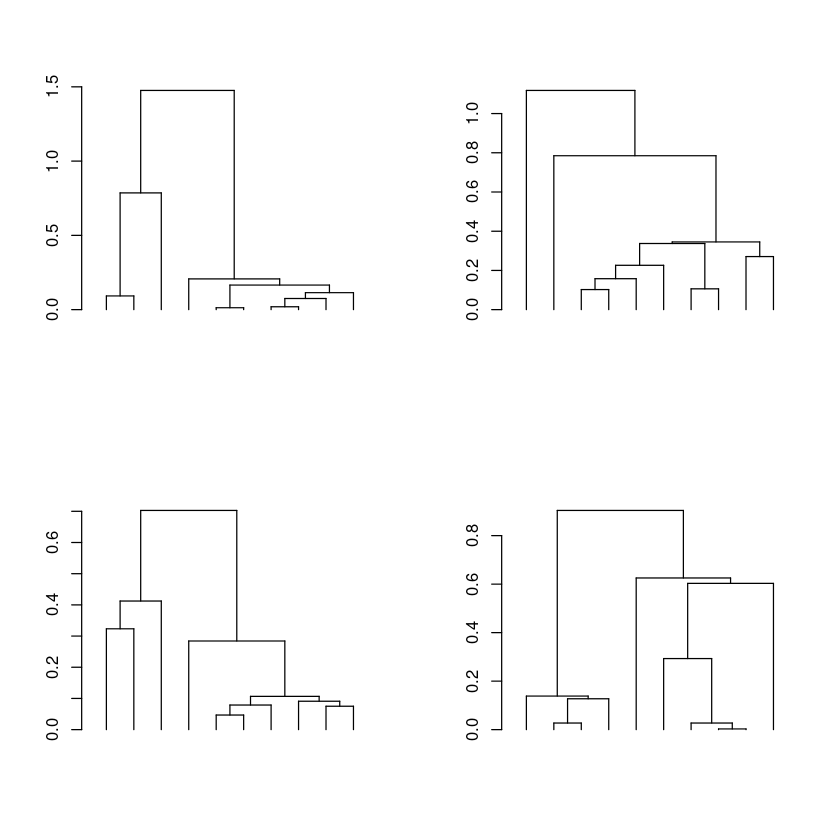

In [21]:
source("https://raw.githubusercontent.com/danny-wilson/danny-wilson.github.io/main/files/coalescent.R")
par(bg="white", mfrow=c(2,2))
for(i in 1:4) {
  tree = sim.coalescent.tree(n=10)
  draw.tree(tree)
}

Try plotting 12 coalescent trees side-by-side on the same scale. What patterns do you notice in the trees?

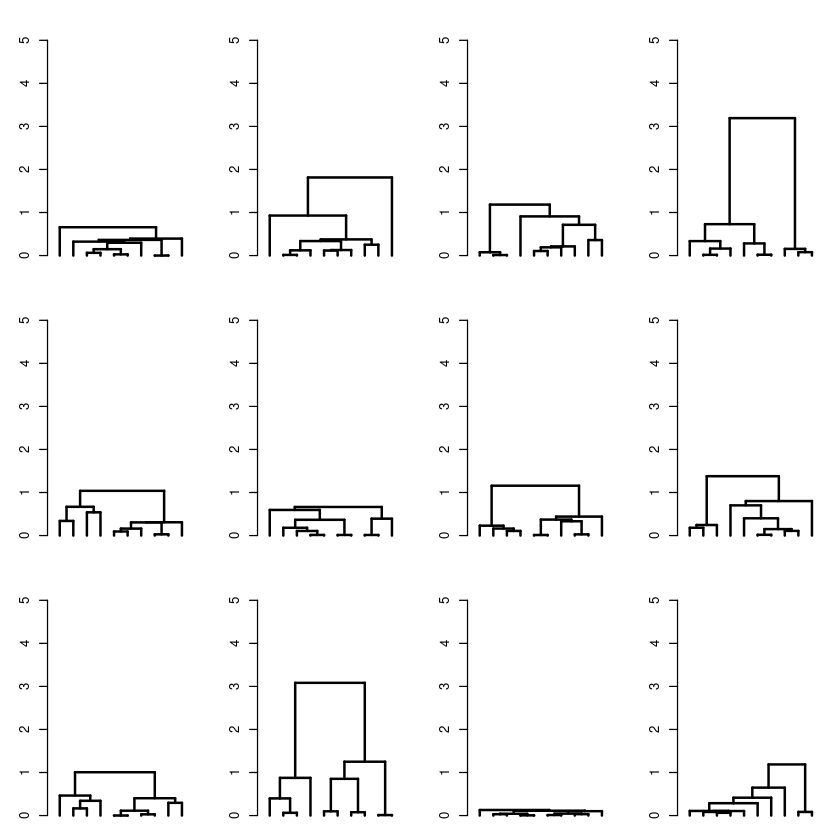

In [22]:
par(mfrow=c(3,4), mar=c(0,2,1,0)+1, bg="white")
for(i in 1:12) draw.tree(sim.coalescent.tree(10),ylim=c(0,5),lwd=2)

<!-- <center><img src="src/Screenshot_coalescent.png" width="30%"></center>-->

The y-axis on these simulated phylogenies shows time in coalescent time units. This is not calendar time and is different again to what you might call phylogenetic time units, in which phylogenies are usually scaled in terms of the expected number of substitutions per site. Instead, it is the number of generations divided by $P N_e$, where $P$ is the ploidy (Zika virus is haploid so $P=1$) and $N_e$ is the effective population size. For pathogen populations, the question of what does the effective population size correspond to biologically is an involved one. See e.g. the methods of Dearlove and Wilson ([Philosophical Transactions of the Royal Society B 368: 20120314](https://rstb.royalsocietypublishing.org/content/368/1614/20120314.full)) if you are interested.

If you need to know, the conversion factor is
$$1 \textrm{ phylogenetic time unit} = \theta/2 \textrm{ coalescent time units}$$
where $\theta/2$ is the expected number of substitutions per site per coalescent time unit and $\theta$ can be estimated directly as the mean pairwise genetic distance.

The point of coalescent time units, confusing though they are, is that populations all behave the same under the standard neutral model once you've applied a linear scaling for the size of the gene pool.

For comparison, we're going to simulate trees in an exponentially growing population. The effect of exponential growth on phylogenies is one of the simplest signatures of population dynamics that is captured by coalescent theory.

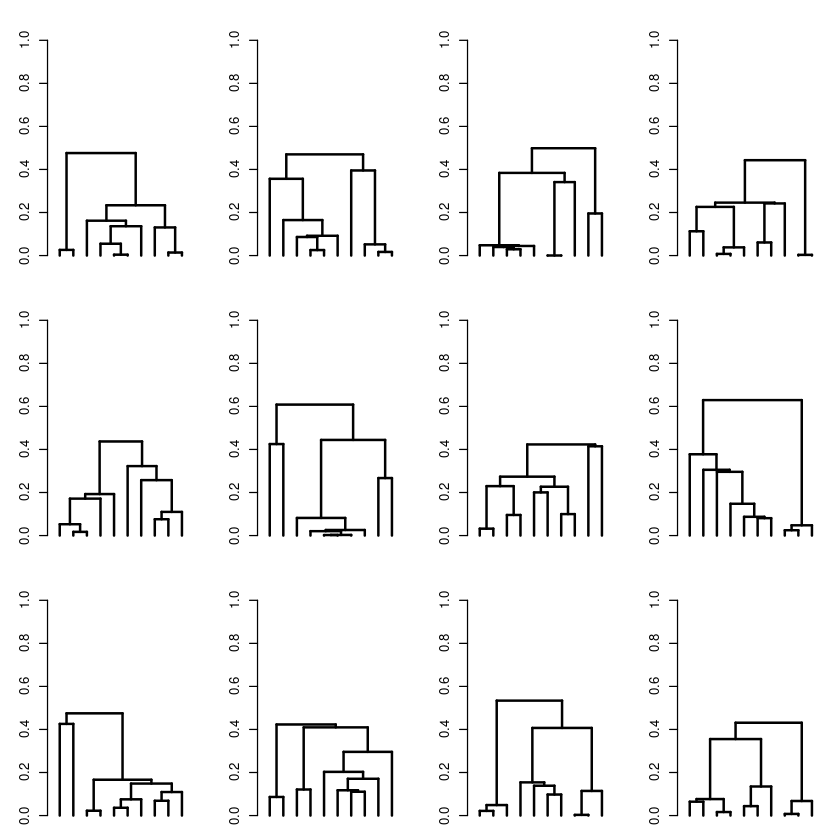

In [23]:
par(mfrow=c(3,4),mar=c(0,2,1,0)+1, bg="white")

for(i in 1:12) draw.tree(expgrowth(sim.coalescent.tree(10),5),ylim=c(0,1),lwd=2)

<!--<center><img src="src/Screenshot_coalescent_growth.png" width="30%"></center>-->

Notice that the scale of the y-axis is much smaller in these simulations. Since the population size is changing, it is necessary to specify that the time units are scaled by the size of the population at the present (i.e. at the time of sampling). The scale is smaller because the depth of a coalescent tree depends on the size of the population, so a population that was much smaller in the recent past can only have a shallow tree. What else do you notice comparing these simulations to the previous simulations under no growth?

The key points you should have noticed are:
- Coalescent trees are symmetric, meaning every topology is equally likely
- In the standard neutral model,
  - There is a lot of variability in branch lengths
  - On average, branches nearer the root tend to be the longest and tips tend to be the shortest
- In exponentially growing populations,
  - The whole tree is compressed
  - But the deeper branches are distorted more than the tips because further back in the phylogeny, the population was smaller
  - This distortion of the relative length of branches near the root versus the tips compared to that expected under no growth is the signature of a growing population
- There is overlap in the distributions of coalescent trees with different growth rates, which means that estimates of growth rates are necessarily subject to substantial statistical uncertainty.

It is only because population growth leaves a signature in phylogenies, and through the phylogenies, on patterns of sequence variation, that we are able to estimate growth rates, and population dynamics more generally, from genetic data, subject to the model assumptions.

Often the phylogenies of an exponentially growing population are referred to as star-shaped. This is shorthand and shouldn't be taken too literally. Only under exceptionally strong growth would the distortion of branch lengths be so strong as to generate phylogenies appearing to have no internal branching structure, in which case the overall compression of the phylogeny would be extreme, likely resulting in very low diversity. Don't forget that estimation of the phylogeny itself is also subject to statistical uncertainty.

### BEAUti and the BEAST

Only because of the exceptional service rendered to the scientific community by the Bayesian phylogenetics package BEAST are the irredeemably feeble acronyms used to name these programs tolerated.

BEAUti (Bayesian Evolutionary Analysis Utility) is a graphical interface that allows a very rich family of evolutionary models to be fitted to molecular sequence data in a Bayesian approach. BEAST (Bayesian Evolutionary Analysis Sampling Trees) implements the statistical analysis set up in BEAUti using a technique known as Markov chain Monte Carlo (MCMC). The results of BEAST can be interpreted using the packaged software Tracer or through standard software such as R.

We are going to set up an analysis of the Asian and South American Zika virus genomes to estimate the rate of global expansion of the outbreak from the earliest Malaysian sequence sampled in 1996 through to the 2015/2016 South American genomes. We're going to go back to the original sequence data to do this, so we need to extract just those sequences in R:

In [24]:
subtree.seq = match(sapply(subtree$tip.label,function(s) unlist(strsplit(s,"_"))[1]),rownames(a))
b = a[subtree.seq,]
rownames(b) = subtree$tip.label
write.fasta(b,"genomes.subtree.fasta")

Next, start BEAUti in [the Terminal](http://localhost:14501) by typing `beauti &`.

From the File menu, click Import Data and choose the `genomes.subtree.fasta` file just created.

You will see that beauti is organized by panels named *Partitions*, *Taxa*, and so on. We're going to go through these panels to set up the model and analysis.

**Taxa**. Use this panel to define groups of individuals for whom you would like to estimate the time of their most recent common ancestor. Previously we used TempEst to get an idea of the timing of the origin of the South American outbreak. To do the same analysis in BEAST, click the + in the bottom left corner, name the new taxon crown and use the panels to include all South American genomes, i.e. exclude only HQ234499.1, EU545988.1, JN860885.1, KF993678.1 and KJ776791.2

Repeat, but call the new taxon *stem* and select the tick box under the *Stem?* column. The stem and crown will date the beginning and end of the branch separating the South American sequences from the Asian sequences.

**Tips**. Similar to TempEst, use this panel to specify the sampling years. Tick the *Use tip dates* box and click the *Parse dates* button, selecting *Defined by a prefix and its order*, with order last and prefix underscore (_). The sampling years should appear in the *Date* column.

**Sites**. Use this panel to specify the substitution model. As previously I would recommend the HKY85 model with *Empirical* base frequencies and no rate heterogeneity, but you are free to experiment.

**Clocks**. I recommend the strict clock model for this analysis, which assumes a constant substitution rate throughout the phylogeny. Relaxed clocks may be useful but there is a trade-off, introducing more statistical uncertainty into estimates of dates.

**Trees**. Here you can specify the *Exponential Growth* tree prior. Advanced users may wish to experiment with other growth models including the nonparametric Bayesian skyline. I recommend you start with a distance-based (UPGMA) tree rather than a random tree because this will reduce the MCMC *burn-in*.

**Priors**. At this point it is necessary to state your subjective prior beliefs regarding the parameters you intend to estimate. If you are not well-informed, you can either
- Conduct *prior sensitivity analysis*, in which you run the whole analysis with different priors and test their effects on the final results.
- Aim to specify some sort of objective/reference/non-informative prior.

For tmrca(crown), tmrca(stem) and treeModel.rootHeight do _not_ change the default *Using Tree Prior*. This option leads to non-sensical inference because it puts multiple priors on the same parameters.

For kappa, the default prior is log-normal with a peak around 3. This looks like a reasonable informative prior since transition:transversion ratios are known to generally exceed 2.

For exponential.popSize, the default prior is a non-informative one over x prior. This is equivalent to placing equal prior weight on any value of the logged parameter, and is a reasonable-looking 'reference' prior. An alternative would be *Infinite Uniform*, equivalent to placing equal prior weight on any positive parameter value. Both priors suffer the major disadvantage of failing to guarantee that the MCMC will converge on a proper posterior distribution, a problem that may come to light if the data are not sufficiently informative as to the parameters.

For exponential.growthRate, the default prior is a double exponential (Laplace) distribution with mean absolute value (the *scale*) of 1.0. This implies equal prior weight to population contraction as to growth. An alternative would be an exponential distribution that only allows positive values, corresponding to population growth. However, this would make it impossible to know whether the data are able to rule out population contraction without help from the prior. The choice of scale is subjective, and an alternative 'reference' prior would be the Infinite Uniform. If unsure (you should be), try conducting a prior sensitivity analysis.

**MCMC**. Specify the File name stem as `beast.mcmc1` and click *Generate BEAST File*, saving it as `beast.mcmc1.xml` in your working directory. *Now repeat* with File name stem `beast.mcmc2` and this time save as `beast.mcmc2.xml`. This is essential because multiple runs are required to establish whether the MCMC has successfully converged to a proper posterior distribution.

**Running BEAST**. The next step is to run the two chains. Open two docker sessions and navigate in both to your working folder (cd ~). In one type
```
beast -java beast.mcmc1.xml
```
and in the other type
```
beast -java beast.mcmc2.xml
```
This will run both cores flat out at 100%, which may make other programs run slowly. You can lower the priority of the BEAST runs by first identifying their process numbers using `top` or `ps` (the processes are called *java*) then typing
```
renice +5 PROCESSNUMBER
```
It took a little over 20 minutes to run the two chains in parallel on my machine.

### Understanding BEAST output

The aim of this part of the practical is to understand the output of the Bayesian phylogenetics/population genetics software BEAST. The output can be read in by standard software such as R, but BEAST has its own bespoke graphical interface called Tracer that we will explore.

**Tracer**. To visualize the output of the BEAST analysis, we will use `tracer &` in the Terminal.

From the File menu, select Import Trace File, navigate to your working folder (`/home/student/work`) and select `beast.mcmc1.log`. Repeat to read in `beast.mcmc2.log`. Notice that the two files are listed in the top left of the screen, and below that is a *Combined* output of the two runs.

#### Assessing MCMC mixing and convergence

Click on *clock.rate* in the list of parameters on the left side bar of tracer. Select the *Trace* panel
<center><img src="src/Screenshot_MCMC_trace_convergence.png" width="30%"></center>

Sometimes the trace is likened to a hairy caterpillar. What it shows is the way that the parameter clock.rate was *sampled* (i.e. simulated) from the posterior distribution by the MCMC over the iterations (labelled State on the x-axis).

You can see that the MCMC explores the posterior distribution by taking a *random walk* through the parameter values. This causes the evident *auto-correlation* in parameter values from iteration to iteration.

The first million iterations are greyed out. This phase of the run is called the burn-in before which the MCMC has reliably converged on the posterior distribution from its initial parameter values. Identifying the length of the burn-in is an inexact science, and we just used the BEAST default of one million iterations.

Following the burn-in, the hairy caterpillar should look fairly flat with relatively modest auto-correlation. If the caterpillar is obviously skewiff or the auto-correlation shows a long *lag* (evident as waves) this means that the MCMC is not *mixing* well, i.e. the random walk is not efficiently exploring the parameter values. A poorly-mixing MCMC needs running for longer, or the proposals used in the random walk need optimizing.

A useful heuristic for how well the MCMC is mixing is the *ESS* (effective sample size), shown in the left side bar for each parameter. The ESS, which is calculated for all iterations after the burn-in, takes account of the auto-correlation to calculate the approximate number of *independent* samples from the posterior distribution. An ESS below 100 suggests serious problems with the MCMC. Every parameter listed in the left side bar needs an adequate ESS.

The next step is to evaluate *convergence* of the MCMC. This was the reason for running multiple chains. In the top left panel labelled *Trace Files*, click first on `beast.mcmc1.log` and then hold Ctrl and click `beast.mcmc2.log`. As you Ctrl-click the second run, you should see its trace super-imposed on top of the trace of the first run. If the two runs have both converged, they should lie on top of each other. You can improve the graph by dragging the right frame of the Tracer window to widen the window until the *Colour by* drop-down list is visible. Select *Colour by: Trace File*. This will make the second trace purple. The two traces should both be well-mixed and should not show systematic differences such as a different mean value. Failure to converge is often accompanied by bad mixing, which will make the two traces clearly non-overlapping during some periods of the MCMC.

If you are satisfied that for every parameter the burn-in is long enough, the ESS is large enough and the MCMC shows good mixing and convergence, it is time to move on.

#### Interpreting the Bayesian posterior distribution

The molecular clock rate is a fundamental quantity for the interpretation of phylogenies because it provides the real-time substitution rate. Only with this information is it possible to convert phylogenetics time units or coalescent time units to calendar time. Previously we estimated the clock rate using TempEst. Now we will use BEAST to estimate this parameter.

Click the *Combined* run from the *Trace Files* list in the top left corner, select clock.rate from the left side bar and choose the *Marginal Prob Distribution* panel on the right.

<center><img src="src/Screenshot_posterior.png" width="30%"></center>

This shows you the posterior distribution of the clock rate approximated by the MCMC: it is essentially a histogram (technically, Tracer shows a smoothed kernel density estimate) of the parameter values sampled by the MCMC runs that you visualized in the trace plots.

The *posterior distribution* is a Bayesian statement about the probable values of the parameter. It takes into account the prior distribution you specified in BEAUti and the observed data as interpreted through the evolutionary model you specified in BEAUti.

How do you use the posterior distribution?

**Point estimates**. If you want to quote a single number to represent your estimate of the parameter, you can summarize the posterior by taking some form of average, such as the:
- **Posterior mean**. This represents the expected value of the parameter, averaging over the uncertainty in the posterior.
- **Posterior median**. There is 50% posterior probability that the true parameter lies below this value and 50% that it lies above it. Unlike the mean, it has the desirable property that the median of any transformation (e.g. logarithm) of the parameter equals the transformation of the median. This property is known as *invariance to transformation* and is shared with maximum likelihood estimates.
- **Posterior mode**. This is the value with the highest posterior density, so in a sense represents one's 'best guess'.

If you want to know more about how to motivate your choice of point estimate, look up Bayesian decision theory, which will introduce the concept of risk/utility functions.

To get Tracer to provide the point estimate of your choosing, click on the *Estimates* panel. I obtained a posterior mean of $7.6\times10^{-4}$. It's best not to copy out `7.6E-4`, because this is not standard scientific notation. Copying out $7.6413\times10^{-4}$ would imply (a) you are confident that the MCMC provides you with 5 significant figures of precision and (b) this level of precision is needed. BEAST helpfully provides a standard error of the mean. I got $3.6\times10^{-6}$ which indicates that the true posterior mean, after accounting for the limited number of iterations of the MCMC, lies somewhere between the sample mean plus and minus two standard errors, i.e. $7.6413\times10^{-4} \pm 2\times3.6\times10^{-6} = (7.569\times10^{-4}, 7.713\times10^{-4})$. This indicates that only one or two significant figures are appropriate. To obtain greater precision combine more chains or run each chain for longer. As a guide, the precision increases only with the square root of the number of iterations, so 100 times as many iterations are needed for 10 times the precision.

I obtained a posterior median of $7.6\times10^{-4}$ as well. For symmetrical distributions, the mean and median will match, as here. For some reason, Tracer could not provide the posterior mode but it would probably have been similar.

**Credibility intervals**. The point estimate does not convey the statistical uncertainty associated with your inference. (This is *different* to the uncertainty represented by the standard error of the mean.) Common statistics used to summarize the uncertainty in the posterior distribution include the:
- **95% highest posterior density (HPD) interval**. This is the narrowest interval within which 95% of the posterior density lies.
- **95% equal-tailed interval**. This is the interval defined by the 2.5% and 97.5% percentiles. There is 2.5% probability the true parameter value lies below the interval and 2.5% probability it lies above it. Like the median, this interval is invariant to transformations of the parameter.

Of course you can choose 90% instead of 95% credibility intervals, or other values, but you must state what they are. I obtained a 95% HPD interval of $(5.3\times10^{-4}, 9.9\times10^{-4})$. Tracer does not produce the equal-tailed interval, even though it is easier to calculate.

Unlike the semantic contortions of classical confidence intervals, a Bayesian can say "I believe there is a 95% probability that the clock rate is between $5.3\times10^{-4}$ and $9.9\times10^{-4}$."

This is a respectably narrow credibility interval, in the sense that there is only around a two-fold difference between the upper and lower bound.
- How do BEAST's estimates of the clock rate compare to TempEst's?

#### The age of the South American Zika virus outbreak

Now you're equipped to interpret the other evolutionary parameters. While you could manually take the clock rate and apply it to one of your previously estimated phylogenies to try to date the emergence of the South American outbreak, this is unnecessary because BEAST co-estimates the phylogeny along with the evolutionary parameters and, because we set it up in BEAUti, it reports the age of the most recent common ancestor (MRCA) of the South American sequences in *tmrca(crown)* and the age of the MRCA of the South American sequences and their next most closely related non-South American sequence in *tmrca(stem)*. It is important to estimate both quantities because, even if the South American outbreak is *monophyletic*, these MRCAs can only provide *bounds* on (i.e. book-end) the date the outbreak began. Note that because we provided the sampling dates of the tips in years, the MRCA date estimates are also in years.
- Can you calculate the credibility interval within which there is *at least* a 95% posterior probability that the true date of the origin of the South American outbreak began?

#### How rapidly did the Asian/South American Zika virus pandemic spread?

The *exponential.growthRate* parameter is the rate of population increase (or decrease, if negative) per year. What does the posterior distribution look like? - How quickly did the outbreak spread? Do you obtain a different rate if you analyse the South American sequences *alone*?

Advanced users might want to explore BEAUti for other methods of estimating population size changes in the Asian/South American Zika genomes or the South American genomes alone. What does the non-parametric Bayesian Skyline method infer?

#### Bayesian inference of the phylogeny

So far we have seen how BEAST estimates evolutionary parameters and tree statistics in a Bayesian fashion, but we have not seen how it estimates the phylogeny, also known as a *genealogy* in a population genetics context. A major difference between the way PhyML and BEAST estimate phylogenies is that the former estimates an unrooted tree in which the branch lengths are in phylogenetic time units (i.e. expected numbers of substitutions per site). In contrast, BEAST is able, when provided with a clock rate specified through the prior or estimated from informative data, to estimate a rooted tree in which the branch lengths are in calendar time. This rooted tree is constrained so that the tips must occur at the specified sampling times, whereas the unrooted tree estimated by PhyML is unconstrained.

Another major difference is that PhyML estimates a point estimate (the maximum likelihood tree) whereas BEAST samples trees from the posterior distribution. Therefore it is necessary to summarize this posterior distribution in some way to provide a point estimate. A consensus tree can be constructed which incorporates nodes that have high posterior probability, as evidenced by their appearance in the majority of sampled trees. The branch lengths might be specified, for example, by the posterior median of each branch taken as an average over the sampled trees in which it appears.

To build a maximum clade credibility (MCC) tree in BEAST:
- Launch TreeAnnotator in [the Terminal](http://localhost:14501) by typing `treeannotator &`
- Set the Burnin to 1000 samples
- Set the Input Tree File to beast.mcmc1.trees
- Select a name for the Output File, e.g. beast.consensus.tree
- Click Run

To view the consensus tree, launch figtree. As for the individual parameters, it is important to quantify the uncertainty associated with the phylogeny point estimate. Explore the options to add labels to the internal nodes of the tree, among which one can choose the posterior probability of the split. If you obtained bootstrap values previously for the maximum likelihood tree, how do the Bayesian posterior probabilities compare?


### Hackathon ideas

- There are now over 600 whole or near-whole Zika virus genomes. Can you apply what you've learned about reference-based mapping earlier to extend your phylogenetic analysis to leverage the information containined in hundreds of genomes? 
- Can you apply what you've learned to understand the early dynamics of other outbreaks such as Foot and Mouth, SARS, Ebola and Coronavirus?